In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [2]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors_test1.pickle','rb') as f:
    descriptorsT1 = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)

In [5]:
# Get descriptors using the new descrioptor extraction method.

descriptorsT1 = []

for object_name, pointCloud, triangles in new_contiguous_point_collection:
            
    t0 = time.time()
    
    try:
        t_descriptors, t_keypoints, t_d_c, _, _ = getSpinImageDescriptorsTest1(
            pointCloud,
            down_resolution = 7,
            cylindrical_quantization = [4,5]
        )
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCloud.shape)


    print("Done with",object_name,"in",time.time()-t0,"seconds.")
    print(" ",pointCloud.shape,triangles.shape)
    print(" ",t_keypoints.shape,t_descriptors.shape)
        
    descriptorsT1.append([
        object_name,
        t_descriptors,
        t_keypoints,
        t_d_c
    ])
    
with open('descriptors/new_complete_res5_4by5_descriptors_test1.pickle','wb') as f:
    pickle.dump(descriptorsT1,f)

Done with Reception-Data61-L5.obj in 35.92829871177673 seconds.
  (40491, 6) (67174, 3)
  (3817, 6) (3817, 20)
Done with Driveway.obj in 74.54228663444519 seconds.
  (56926, 6) (88560, 3)
  (4864, 6) (4864, 20)
Done with Apartment.obj in 127.77676129341125 seconds.
  (72859, 6) (126700, 3)
  (6097, 6) (6097, 20)
Done with Workstations-Data61-L4.obj in 145.21020936965942 seconds.
  (73215, 6) (121972, 3)
  (7064, 6) (7064, 20)
Done with Kitchen-Data61-L4.obj in 265.8257749080658 seconds.
  (102337, 6) (176558, 3)
  (9871, 6) (9871, 20)
Done with HallWayToKitchen-Data61-L4.obj in 18.013182163238525 seconds.
  (26398, 6) (44989, 3)
  (2983, 6) (2983, 20)
Done with StairWell-Data61-L4.obj in 162.20634531974792 seconds.
  (77903, 6) (129848, 3)
  (7647, 6) (7647, 20)


In [3]:
# We'll use only a 300 samples for this.
with open('sample_points.pickle','rb') as f:
    sample_points = pickle.load(f)
    
sample_points_300 = np.random.choice(1000,300,False)

len(sample_points), len(sample_points_300)

(1000, 300)

# Step 1.1: Raw spaces (validation)

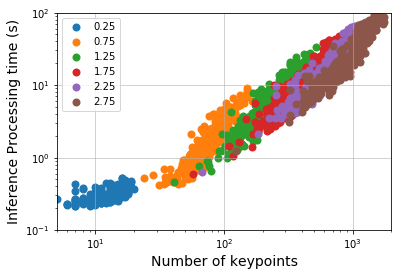

In [4]:
with open('testing_results/partial/raw_evaluation_properties.pickle','rb') as f:
    raw_evaluation_properties = pickle.load(f)
    
plt.grid(alpha = 0.7)
plt.ylim(0.1,100)
plt.xlim(5,2000)
plt.xlabel("Number of keypoints", fontsize = 14)
plt.ylabel("Inference Processing time (s)", fontsize = 14)
plt.xticks([10,100,1000],[10,100,1000])

overall_simp_properties = []

for radius, properties in raw_evaluation_properties:
    #properties = np.asarray(properties)
    simp_properties = []
    for ratio_s, index_s, score_s, proc_time in properties:
        simp_properties.append([
            radius, 
            ratio_s[0],
            proc_time
        ])
        
    
    simp_properties = np.asarray(simp_properties)
    plt.scatter(
        simp_properties[:,1],
        simp_properties[:,2],
        #facecolors = 'none',
        linewidth = 2,
        label = str(radius)
    )
    
    overall_simp_properties.append([
        radius,
        np.mean(simp_properties[:,1]),
        np.std(simp_properties[:,1]),
        np.mean(simp_properties[:,2]),
        np.std(simp_properties[:,2])
    ])

plt.xscale('log')
plt.yscale('log')
plt.legend()
    
#radius, properties[1]
overall_simp_properties =np.asarray(overall_simp_properties)

In [9]:
descriptors = descriptors

#keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp_try")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_raw_eval_propeties = []

for radius in np.arange(0.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
        
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                #keypoint_cap,
                #strict_cap = True,
                desc_new = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue
            
        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                 
            with bz2.BZ2File(partial_results_path+'/raw_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
            
            t1  = time.time()
            
    exp_raw_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open(partial_results_path+'/raw_eval_properties.pickle', 'wb') as f:
        pickle.dump(exp_raw_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

radius = 0.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.25 : Done with 2, in 0.531 seconds. Error rate 0.500
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.257 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 68, in 17.081 seconds. Error rate 0.809
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.244 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 134, in 16.951 seconds. Error rate 0.828
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.244 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 200, in 17.055 seconds. Error rate 0.835
   (7, 7) (7, 7, 2) (7, 7, 2) in 0.265 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 266, in 17.222 seconds. Error rate 0.823
   (9, 7) (9, 7, 2) (9, 7, 2) in 0.248 seconds
0.25  Total Time to match 78.109 seconds.
radius = 0.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 2, in 0.676 seconds. Error rate 0.500
   (62, 7) (62, 7, 2) (62, 7, 2) in 0.365 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 68, in 26.819 seconds. Error rate 0.750
   (123, 7) (123, 7, 2) (123, 7, 2) in 0.548 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 134, in 27.820 seconds. Error rate 0.739
   (70, 7) (70, 7, 2) (70, 7, 2) in 0.377 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 200, in 26.024 seconds. Error rate 0.765
   (31, 7) (31, 7, 2) (31, 7, 2) in 0.307 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 266, in 26.214 seconds. Error rate 0.778
   (40, 7) (40, 7, 2) (40, 7, 2) in 0.299 seconds
0.75  Total Time to match 125.245 seconds.
radius = 1.25
   1.25 : Done with 2, in 1.301 seconds. Error rate 1.000
   (147, 7) (147, 7, 2) (147, 7, 2) in 0.581 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 52.120 seconds. Error rate 0.676
   (269, 7) (269, 7, 2) (269, 7, 2) in 0.994 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 56.438 seconds. Error rate 0.590
   (227, 7) (227, 7, 2) (227, 7, 2) in 0.826 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 52.694 seconds. Error rate 0.620
   (120, 7) (120, 7, 2) (120, 7, 2) in 0.537 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 51.836 seconds. Error rate 0.628
   (144, 7) (144, 7, 2) (144, 7, 2) in 0.568 seconds
1.25  Total Time to match 253.001 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 2.123 seconds. Error rate 0.500
   (246, 7) (246, 7, 2) (246, 7, 2) in 0.871 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 98.406 seconds. Error rate 0.412
   (512, 7) (512, 7, 2) (512, 7, 2) in 1.889 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 111.217 seconds. Error rate 0.373
   (392, 7) (392, 7, 2) (392, 7, 2) in 1.403 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 101.859 seconds. Error rate 0.430
   (283, 7) (283, 7, 2) (283, 7, 2) in 1.109 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 99.304 seconds. Error rate 0.436
   (361, 7) (361, 7, 2) (361, 7, 2) in 1.253 seconds
1.75  Total Time to match 488.616 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 2, in 3.931 seconds. Error rate 0.500
   (368, 7) (368, 7, 2) (368, 7, 2) in 1.465 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 68, in 175.529 seconds. Error rate 0.324
   (698, 7) (698, 7, 2) (698, 7, 2) in 2.739 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 134, in 192.895 seconds. Error rate 0.343
   (507, 7) (507, 7, 2) (507, 7, 2) in 1.842 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 200, in 183.871 seconds. Error rate 0.315
   (478, 7) (478, 7, 2) (478, 7, 2) in 2.126 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 266, in 170.641 seconds. Error rate 0.323
   (581, 7) (581, 7, 2) (581, 7, 2) in 2.161 seconds
2.25  Total Time to match 860.632 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 2, in 5.644 seconds. Error rate 0.000
   (454, 7) (454, 7, 2) (454, 7, 2) in 1.651 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 68, in 282.151 seconds. Error rate 0.324
   (1040, 7) (1040, 7, 2) (1040, 7, 2) in 4.353 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 134, in 303.052 seconds. Error rate 0.306
   (639, 7) (639, 7, 2) (639, 7, 2) in 2.393 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 200, in 286.387 seconds. Error rate 0.315
   (710, 7) (710, 7, 2) (710, 7, 2) in 3.705 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 266, in 269.816 seconds. Error rate 0.308
   (762, 7) (762, 7, 2) (762, 7, 2) in 3.167 seconds
2.75  Total Time to match 1364.204 seconds.


In [10]:
descriptors = descriptorsT1

#keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp_try")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_raw_eval_propeties = []

for radius in np.arange(0.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
        
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                #keypoint_cap,
                #strict_cap = True,
                desc_new = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue
            
        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                 
            with bz2.BZ2File(partial_results_path+'/raw_{}_partial_scores_T1.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
            
            t1  = time.time()
            
    exp_raw_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open(partial_results_path+'/raw_eval_properties_T1.pickle', 'wb') as f:
        pickle.dump(exp_raw_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

radius = 0.25
   0.25 : Done with 2, in 0.528 seconds. Error rate 1.000
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.280 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 68, in 17.817 seconds. Error rate 0.779
   (10, 7) (10, 7, 2) (10, 7, 2) in 0.261 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 134, in 17.719 seconds. Error rate 0.806
   (8, 7) (8, 7, 2) (8, 7, 2) in 0.240 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 200, in 17.533 seconds. Error rate 0.820
   (7, 7) (7, 7, 2) (7, 7, 2) in 0.262 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 266, in 17.563 seconds. Error rate 0.820
   (11, 7) (11, 7, 2) (11, 7, 2) in 0.272 seconds
0.25  Total Time to match 80.943 seconds.
radius = 0.75
   0.75 : Done with 2, in 0.857 seconds. Error rate 1.000
   (69, 7) (69, 7, 2) (69, 7, 2) in 0.449 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 68, in 28.838 seconds. Error rate 0.794
   (116, 7) (116, 7, 2) (116, 7, 2) in 0.609 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 134, in 28.608 seconds. Error rate 0.791
   (87, 7) (87, 7, 2) (87, 7, 2) in 0.416 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 200, in 28.022 seconds. Error rate 0.800
   (29, 7) (29, 7, 2) (29, 7, 2) in 0.310 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.75 : Done with 266, in 27.605 seconds. Error rate 0.801
   (36, 7) (36, 7, 2) (36, 7, 2) in 0.313 seconds
0.75  Total Time to match 131.775 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 2, in 1.533 seconds. Error rate 0.500
   (151, 7) (151, 7, 2) (151, 7, 2) in 0.737 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 55.950 seconds. Error rate 0.456
   (282, 7) (282, 7, 2) (282, 7, 2) in 1.063 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 60.294 seconds. Error rate 0.500
   (223, 7) (223, 7, 2) (223, 7, 2) in 0.965 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 55.578 seconds. Error rate 0.505
   (128, 7) (128, 7, 2) (128, 7, 2) in 0.546 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 55.648 seconds. Error rate 0.500
   (170, 7) (170, 7, 2) (170, 7, 2) in 0.606 seconds
1.25  Total Time to match 268.866 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 2.405 seconds. Error rate 0.500
   (275, 7) (275, 7, 2) (275, 7, 2) in 0.959 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 105.453 seconds. Error rate 0.368
   (528, 7) (528, 7, 2) (528, 7, 2) in 2.126 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 116.750 seconds. Error rate 0.328
   (354, 7) (354, 7, 2) (354, 7, 2) in 1.361 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 106.955 seconds. Error rate 0.305
   (290, 7) (290, 7, 2) (290, 7, 2) in 1.192 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 103.877 seconds. Error rate 0.274
   (352, 7) (352, 7, 2) (352, 7, 2) in 1.251 seconds
1.75  Total Time to match 511.225 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 2, in 3.887 seconds. Error rate 0.500
   (354, 7) (354, 7, 2) (354, 7, 2) in 1.387 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 68, in 181.438 seconds. Error rate 0.191
   (728, 7) (728, 7, 2) (728, 7, 2) in 2.926 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:688: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 134, in 200.081 seconds. Error rate 0.209
   (482, 7) (482, 7, 2) (482, 7, 2) in 1.905 seconds


KeyboardInterrupt: 

In [4]:
descriptors = descriptors

#keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp_try")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_raw_eval_propeties = []

for radius in np.arange(0.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
        
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                old=True,
                #keypoint_cap,
                #strict_cap = True,
                desc_new = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue
            
        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                 
            with bz2.BZ2File(partial_results_path+'/raw_{}_partial_scores_T1.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
            
            t1  = time.time()
            
    exp_raw_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open(partial_results_path+'/raw_eval_properties_T1.pickle', 'wb') as f:
        pickle.dump(exp_raw_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

radius = 0.25
   0.25 : Done with 2, in 0.671 seconds. Error rate 1.000
   (17, 7) (17, 7, 2) (17, 7, 2) in 0.307 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 68, in 19.380 seconds. Error rate 0.779
   (9, 7) (9, 7, 2) (9, 7, 2) in 0.272 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 134, in 19.630 seconds. Error rate 0.806
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.289 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 200, in 18.437 seconds. Error rate 0.825
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.275 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 266, in 19.493 seconds. Error rate 0.816
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.287 seconds
0.25  Total Time to match 88.467 seconds.
radius = 0.75
   0.75 : Done with 2, in 1.039 seconds. Error rate 1.000
   (114, 7) (114, 7, 2) (114, 7, 2) in 0.547 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 68, in 31.322 seconds. Error rate 0.706
   (77, 7) (77, 7, 2) (77, 7, 2) in 0.483 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 134, in 29.690 seconds. Error rate 0.694
   (76, 7) (76, 7, 2) (76, 7, 2) in 0.446 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 200, in 32.911 seconds. Error rate 0.680
   (76, 7) (76, 7, 2) (76, 7, 2) in 0.434 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 266, in 30.563 seconds. Error rate 0.673
   (118, 7) (118, 7, 2) (118, 7, 2) in 0.657 seconds
0.75  Total Time to match 147.866 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 2, in 2.434 seconds. Error rate 0.000
   (263, 7) (263, 7, 2) (263, 7, 2) in 1.311 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 63.270 seconds. Error rate 0.029
   (325, 7) (325, 7, 2) (325, 7, 2) in 1.369 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 57.283 seconds. Error rate 0.052
   (201, 7) (201, 7, 2) (201, 7, 2) in 1.045 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 68.419 seconds. Error rate 0.045
   (181, 7) (181, 7, 2) (181, 7, 2) in 0.782 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 63.171 seconds. Error rate 0.053
   (375, 7) (375, 7, 2) (375, 7, 2) in 1.975 seconds
1.25  Total Time to match 304.944 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 4.273 seconds. Error rate 0.000
   (495, 7) (495, 7, 2) (495, 7, 2) in 2.440 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 116.701 seconds. Error rate 0.000
   (592, 7) (592, 7, 2) (592, 7, 2) in 2.711 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 109.933 seconds. Error rate 0.007
   (343, 7) (343, 7, 2) (343, 7, 2) in 1.727 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 127.120 seconds. Error rate 0.010
   (333, 7) (333, 7, 2) (333, 7, 2) in 1.337 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 118.857 seconds. Error rate 0.008
   (792, 7) (792, 7, 2) (792, 7, 2) in 4.419 seconds
1.75  Total Time to match 570.659 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 2, in 8.333 seconds. Error rate 0.000
   (873, 7) (873, 7, 2) (873, 7, 2) in 4.856 seconds


KeyboardInterrupt: 

# Step 1.2: RANSAC-generalized spaces validation

In [5]:
#descriptors = new_trytest_descriptors

keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp_try")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_eval_propeties = []

for radius in np.arange(0.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                old=True,
                #key_cap=keypoint_cap,
                #strict_cap=True,
                desc_new=True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                        
            with bz2.BZ2File(partial_results_path+'/ransac_{}_partial_scores.pickle.bz2'.format(radius, keypoint_cap), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()
            
    exp_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open(partial_results_path+'/ransac_eval_properties_{}.pickle'.format(keypoint_cap), 'wb') as f:
        pickle.dump(exp_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    

    #print(len(partial_lengths))
       

radius = 0.25
   0.25 : Done with 2, in 0.777 seconds. Error rate 1.000
   (17, 7) (17, 7, 2) (17, 7, 2) in 0.373 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 68, in 19.025 seconds. Error rate 0.809
   (11, 7) (11, 7, 2) (11, 7, 2) in 0.283 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 134, in 18.826 seconds. Error rate 0.828
   (17, 7) (17, 7, 2) (17, 7, 2) in 0.303 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 200, in 19.579 seconds. Error rate 0.810
   (11, 7) (11, 7, 2) (11, 7, 2) in 0.294 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 266, in 19.472 seconds. Error rate 0.835
   (12, 7) (12, 7, 2) (12, 7, 2) in 0.273 seconds
0.25  Total Time to match 87.076 seconds.
radius = 0.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 2, in 1.075 seconds. Error rate 0.500
   (109, 7) (109, 7, 2) (109, 7, 2) in 0.618 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 68, in 31.363 seconds. Error rate 0.721
   (71, 7) (71, 7, 2) (71, 7, 2) in 0.396 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 134, in 29.595 seconds. Error rate 0.791
   (79, 7) (79, 7, 2) (79, 7, 2) in 0.502 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 200, in 32.069 seconds. Error rate 0.775
   (78, 7) (78, 7, 2) (78, 7, 2) in 0.412 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 266, in 30.311 seconds. Error rate 0.774
   (99, 7) (99, 7, 2) (99, 7, 2) in 0.492 seconds
0.75  Total Time to match 146.450 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 2, in 2.303 seconds. Error rate 0.500
   (262, 7) (262, 7, 2) (262, 7, 2) in 1.317 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 60.481 seconds. Error rate 0.412
   (308, 7) (308, 7, 2) (308, 7, 2) in 1.210 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 55.021 seconds. Error rate 0.455
   (224, 7) (224, 7, 2) (224, 7, 2) in 1.038 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 66.280 seconds. Error rate 0.445
   (177, 7) (177, 7, 2) (177, 7, 2) in 0.697 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 61.973 seconds. Error rate 0.440
   (385, 7) (385, 7, 2) (385, 7, 2) in 1.887 seconds
1.25  Total Time to match 295.875 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 4.135 seconds. Error rate 0.000
   (470, 7) (470, 7, 2) (470, 7, 2) in 2.445 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 110.500 seconds. Error rate 0.250
   (579, 7) (579, 7, 2) (579, 7, 2) in 2.567 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 103.800 seconds. Error rate 0.246
   (378, 7) (378, 7, 2) (378, 7, 2) in 1.653 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 125.508 seconds. Error rate 0.280
   (355, 7) (355, 7, 2) (355, 7, 2) in 1.331 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 120.603 seconds. Error rate 0.267
   (774, 7) (774, 7, 2) (774, 7, 2) in 4.328 seconds
1.75  Total Time to match 559.062 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 2, in 8.006 seconds. Error rate 0.000
   (829, 7) (829, 7, 2) (829, 7, 2) in 4.648 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 68, in 188.782 seconds. Error rate 0.088
   (907, 7) (907, 7, 2) (907, 7, 2) in 4.507 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 134, in 178.880 seconds. Error rate 0.119
   (530, 7) (530, 7, 2) (530, 7, 2) in 2.259 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 200, in 213.575 seconds. Error rate 0.130
   (586, 7) (586, 7, 2) (586, 7, 2) in 2.396 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 266, in 215.736 seconds. Error rate 0.132
   (1278, 7) (1278, 7, 2) (1278, 7, 2) in 8.503 seconds
2.25  Total Time to match 962.243 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 2, in 13.553 seconds. Error rate 0.000
   (1417, 7) (1417, 7, 2) (1417, 7, 2) in 9.291 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 68, in 294.573 seconds. Error rate 0.103
   (1221, 7) (1221, 7, 2) (1221, 7, 2) in 6.326 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 134, in 276.200 seconds. Error rate 0.119
   (772, 7) (772, 7, 2) (772, 7, 2) in 3.687 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 200, in 334.204 seconds. Error rate 0.145
   (825, 7) (825, 7, 2) (825, 7, 2) in 3.973 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 266, in 330.388 seconds. Error rate 0.143
   (1493, 7) (1493, 7, 2) (1493, 7, 2) in 11.342 seconds
2.75  Total Time to match 1491.959 seconds.


In [7]:
# Old NN-matcher
descriptors = descriptors

keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_eval_propeties = []

for radius in np.arange(1.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                key_cap=keypoint_cap,
                strict_cap=True,
                desc_new=True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                        
            with bz2.BZ2File('testing_results/partial_exp/ransac_{}_partial_scores_cap_{}.pickle.bz2'.format(radius, keypoint_cap), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()
            
    exp_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/ransac_eval_properties_{}.pickle'.format(keypoint_cap), 'wb') as f:
        pickle.dump(exp_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    

    #print(len(partial_lengths))
       

radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 2, in 4.017 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) in 2.760 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 409.002 seconds. Error rate 0.618
   (100, 7) (100, 7, 2) (100, 7, 2) in 5.801 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 378.619 seconds. Error rate 0.612
   (100, 7) (100, 7, 2) (100, 7, 2) in 2.161 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 330.606 seconds. Error rate 0.635
   (100, 7) (100, 7, 2) (100, 7, 2) in 7.172 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 346.869 seconds. Error rate 0.628
   (100, 7) (100, 7, 2) (100, 7, 2) in 2.470 seconds
1.25  Total Time to match 1611.411 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 13.056 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) in 9.381 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 752.585 seconds. Error rate 0.603
   (100, 7) (100, 7, 2) (100, 7, 2) in 8.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 726.312 seconds. Error rate 0.582
   (100, 7) (100, 7, 2) (100, 7, 2) in 3.305 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 717.337 seconds. Error rate 0.550
   (100, 7) (100, 7, 2) (100, 7, 2) in 10.682 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 709.352 seconds. Error rate 0.549
   (100, 7) (100, 7, 2) (100, 7, 2) in 6.094 seconds
1.75  Total Time to match 3191.538 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 2, in 26.231 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) in 18.652 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 68, in 1174.840 seconds. Error rate 0.441
   (100, 7) (100, 7, 2) (100, 7, 2) in 12.820 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 134, in 1239.254 seconds. Error rate 0.418
   (100, 7) (100, 7, 2) (100, 7, 2) in 5.743 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 200, in 1258.419 seconds. Error rate 0.395
   (100, 7) (100, 7, 2) (100, 7, 2) in 20.545 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.25 : Done with 266, in 1202.143 seconds. Error rate 0.406
   (100, 7) (100, 7, 2) (100, 7, 2) in 9.065 seconds
2.25  Total Time to match 5400.502 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 2, in 42.231 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) in 29.020 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   2.75 : Done with 68, in 1854.659 seconds. Error rate 0.441
   (100, 7) (100, 7, 2) (100, 7, 2) in 15.640 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:648: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:658: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:665: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.75 : Done with 134, in 1872.096 seconds. Error rate 0.478
   (100, 7) (100, 7, 2) (100, 7, 2) in 9.049 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:648: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:658: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:665: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.75 : Done with 200, in 1921.080 seconds. Error rate 0.475
   (100, 7) (100, 7, 2) (100, 7, 2) in 29.955 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:648: RuntimeWarning: invalid value encountered in true_divide
  similarity_of_angle = np.sum(np.multiply(unq_diff_qry_kps,unq_diff_ref_kps), axis = -1)/np.multiply(Norm_unq_diff_qry_kps,Norm_unq_diff_ref_kps)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:658: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:665: RuntimeWarning: invalid value encountered in greater
  good_match_threshold*np.ones(similarity_of_shape.shape)


   2.75 : Done with 266, in 1710.505 seconds. Error rate 0.432
   (100, 7) (100, 7, 2) (100, 7, 2) in 10.554 seconds
2.75  Total Time to match 8095.553 seconds.


In [ ]:
descriptors = descriptors

for keypoint_cap in [30,50,70]:

#keypoint_cap = 100

    partial_results_path = os.path.join(results_path,"partial_capped_"+str(keypoint_cap))

    if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)

    exp_eval_propeties = []

    for radius in np.arange(0.25,3.1,0.5):

        t0 = time.time()
        t1 = time.time()

        partial_scores_pool = []
        per_radius_properties = []

        print("radius =",radius)

        for s_i in sample_points_300:

            t3 = time.time()

            obj_, object_name, original_vertex = sample_points[s_i]

            pointCloud = []

            try:
                trial = np.random.randint(5)

                with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                    ransac_trial_point_collection = pickle.load(f)

                object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

                ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

                dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
                pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            except:
                print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
                continue

            t4 = time.time()

            #if len(gen_planes) == 0: continue
            if len(pointCloud) == 0: continue

            local_keypoint_matches = []

            try:
                obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                    [obj_, object_name, original_vertex], 
                    pointCloud, 
                    descriptors,
                    key_cap=keypoint_cap,
                    strict_cap=True
                )

            except Exception as ex:
                print(ex)
                print("skipped",object_name)
                continue

            if len(local_keypoint_matches) == 0: 
                print("skipped",object_name)
                continue

            t5 = time.time()

            partial_scores_pool.append([
                [obj_, object_name, original_vertex], 
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            per_radius_properties.append([
                diff_ratios.shape,
                diff_indexs.shape,
                diff_scores.shape,
                [t5 - t4, t4 -t3] # inference time, extraction time
            ])

            if len(partial_scores_pool) % 66 == 2:

                partial_errors_pool = NN_matcher(partial_scores_pool)
                print(keypoint_cap,"  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                    len(partial_scores_pool),
                    time.time()-t1,
                    np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
                ))
                print("  ",
                      diff_ratios.shape,
                      diff_indexs.shape,
                      diff_scores.shape,
                      "extrated in {:.3f} seconds, inferred in {:.3f} seconds".format(t4 - t3, t5 - t4)
                     )

                t1  = time.time()
                
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)

        exp_eval_propeties.append([
            radius,
            per_radius_properties
        ])

        with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'wb') as f:
            pickle.dump(exp_eval_propeties,f)

        print(keypoint_cap,radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))


radius = 0.25
30    0.25 : Done with 2, in 0.569 seconds. Error rate 1.000
   (11, 7) (11, 7, 2) (11, 7, 2) extrated in 0.036 seconds, inferred in 0.222 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 68, in 21.763 seconds. Error rate 0.926
   (18, 7) (18, 7, 2) (18, 7, 2) extrated in 0.035 seconds, inferred in 0.384 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 134, in 26.178 seconds. Error rate 0.910
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.040 seconds, inferred in 0.271 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 200, in 32.469 seconds. Error rate 0.900
   (18, 7) (18, 7, 2) (18, 7, 2) extrated in 0.039 seconds, inferred in 0.304 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 266, in 35.957 seconds. Error rate 0.883
   (9, 7) (9, 7, 2) (9, 7, 2) extrated in 0.050 seconds, inferred in 0.241 seconds
30 0.25  Total Time to match 137.291 seconds.
radius = 0.75
30    0.75 : Done with 2, in 1.144 seconds. Error rate 1.000
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.037 seconds, inferred in 0.587 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 68, in 117.597 seconds. Error rate 0.838
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.039 seconds, inferred in 2.307 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 134, in 115.996 seconds. Error rate 0.858
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.034 seconds, inferred in 0.534 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:670: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 200, in 128.594 seconds. Error rate 0.830
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.036 seconds, inferred in 2.144 seconds


# Step 1.3: Results

In [22]:
results_partials_caps = []


for keypoint_cap in [30,50,70]:

    ransac_errors = []

    for radius in np.arange(0.25, 3.1, 0.5):

        try:
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'r') as bz2_f:
                partial_scores_pool = pickle.load(bz2_f) 

        except:
            print("Error getting Raw scores for",radius)
            continue

        partial_errors_pool = NN_matcher(partial_scores_pool)
        correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
        intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

        print(keypoint_cap,radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
        print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

        ransac_errors.append([
            radius,
            np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'rb') as f:
        exp_eval_propeties = pickle.load(f)
        
    overall_simp_properties = []

    for radius, properties in exp_eval_propeties:
        
        properties = np.asarray(properties)

        simp_properties = []

        for ratio_s, index_s, score_s, [proc_time, extrct_time] in properties:
            simp_properties.append([
                radius, 
                ratio_s[0],
                proc_time,
                extrct_time
            ])

        simp_properties = np.asarray(simp_properties)
        
        overall_simp_properties.append([
            radius,
            np.mean(simp_properties[:,1]),
            np.std(simp_properties[:,1]),
            np.mean(simp_properties[:,2]),
            np.std(simp_properties[:,2]),
            np.mean(simp_properties[:,3]),
            np.std(simp_properties[:,3])
        ])
                
    results_partials_caps.append([
        keypoint_cap,
        np.asarray(ransac_errors),
        np.asarray(overall_simp_properties)
    ])
    
with open('testing_results/partial_exp/results_partials_caps.pickle', 'wb') as f:
    pickle.dump(results_partials_caps,f)
    

30 0.25 (Ransac) P1 Error Rate: 0.868421052631579
   (Ransac) P2 Error Rate: 6.211 (± 3.706)
30 0.75 (Ransac) P1 Error Rate: 0.8270676691729323
   (Ransac) P2 Error Rate: 5.604 (± 3.458)
30 1.25 (Ransac) P1 Error Rate: 0.6804511278195489
   (Ransac) P2 Error Rate: 3.332 (± 3.071)
30 1.75 (Ransac) P1 Error Rate: 0.6729323308270677
   (Ransac) P2 Error Rate: 3.200 (± 2.610)
30 2.25 (Ransac) P1 Error Rate: 0.6578947368421053
   (Ransac) P2 Error Rate: 3.206 (± 2.604)
30 2.75 (Ransac) P1 Error Rate: 0.6278195488721805
   (Ransac) P2 Error Rate: 3.069 (± 2.401)
50 0.25 (Ransac) P1 Error Rate: 0.8721804511278195
   (Ransac) P2 Error Rate: 6.589 (± 3.350)
50 0.75 (Ransac) P1 Error Rate: 0.8270676691729323
   (Ransac) P2 Error Rate: 4.527 (± 3.210)
50 1.25 (Ransac) P1 Error Rate: 0.6992481203007519
   (Ransac) P2 Error Rate: 3.644 (± 3.384)
50 1.75 (Ransac) P1 Error Rate: 0.5601503759398496
   (Ransac) P2 Error Rate: 3.200 (± 3.030)
50 2.25 (Ransac) P1 Error Rate: 0.5413533834586466
   (Ransac

Text(0.5, 1.0, 'NN-matcher')

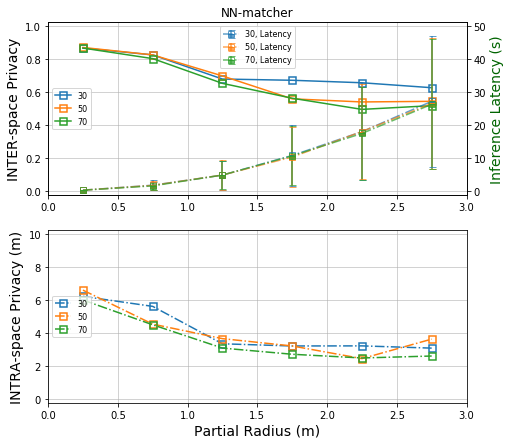

In [25]:
fig=plt.figure(figsize=(7.5, 7))

markersize = 7
linewidth = 1.5

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)
ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

with open('testing_results/partial_exp/results_partials_caps.pickle', 'rb') as f:
    results_partials_caps = pickle.load(f)
    
for cap, ransac_errors, properties in results_partials_caps:

    ax2.plot(
        ransac_errors[:,0],
        ransac_errors[:,2],
        '-.s',
        linewidth = linewidth,
        fillstyle = 'none',
        mew = linewidth,markersize = markersize,
        label = str(cap)
    )

    ax1.plot(
        ransac_errors[:,0],
        ransac_errors[:,1],
        "-s",
        linewidth = linewidth,
        fillstyle = 'none',
        mew = linewidth,markersize = markersize,
        label = str(cap)
    )

    ax3.errorbar(
        properties[:,0],
        properties[:,3],
        properties[:,4],
        marker = 's',
        alpha = 0.7,
        markersize = markersize-1,
        linestyle = '-.',
        fillstyle = 'bottom',
        #color = 'tab:green',
        capsize = markersize/2,
        label = str(cap)+", Latency"
    );

ax2.legend(loc = "center left", ncol = 1,fontsize = 8);#, bbox_to_anchor=(1.1, 1.5));
ax1.legend(loc = "center left", ncol = 1, fontsize = 8);# bbox_to_anchor=(1.1, 1.5));
#handles, labels = ax1.get_legend_handles_labels()

handles.append(p3), labels.append("Latency, Generalized")
#ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
ax3.legend(loc = 'upper center', ncol = 1, fontsize = 8)
#ax1.set_xlabel("Partial Radius")

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


Text(0.5, 1.0, 'NN-matcher')

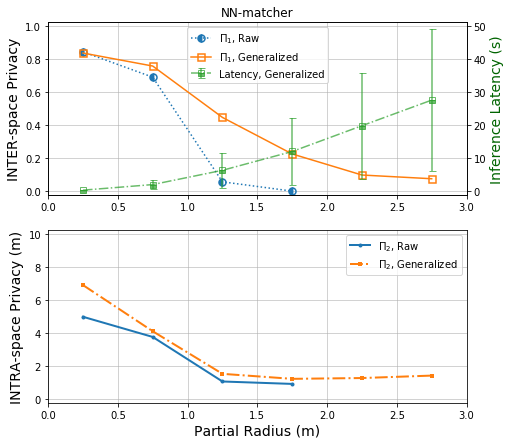

In [13]:
fig=plt.figure(figsize=(7.5, 7))

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));
handles, labels = ax1.get_legend_handles_labels()

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

p3 = ax3.errorbar(
    overall_simp_properties[:,0],
    overall_simp_properties[:,3],
    overall_simp_properties[:,4],
    marker = 's',
    alpha = 0.7,
    markersize = markersize-1,
    linestyle = '-.',
    fillstyle = 'bottom',
    color = 'tab:green',
    capsize = markersize/2,
    label = "Latency"
);

handles.append(p3), labels.append("Latency, Generalized")
ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
#ax1.set_xlabel("Partial Radius")

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


# Functions

In [35]:

def getQuantizedPointCloudOnlyTEST(_point_cloud,scale = 5, verbose = False):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    
    round_new_pointcloud_only = (1.0/scale)*np.around(scale*_point_cloud[:,:3],decimals=0)
    unq_round_new_pointcloud, indices = np.unique(round_new_pointcloud_only,axis = 0, return_index = True)
    
    #print()
    n_pointCloud = np.hstack((unq_round_new_pointcloud, np_pointCloud[indices,3:]))
        
    return n_pointCloud


In [36]:
# Getting the "spin image" descriptors for a given point cloud    
def getSpinImageDescriptorsTest(_point_cloud,
                            resolution = 20,
                            normalize = True,
                            down_resolution = 3, #keypoint resolution
                            #localize = False,
                            local_radius = 1.0,
                            cylindrical_quantization = [10,20],
                            verbose = False,
                            old = False,
                            key_cap = 50, 
                            strict_cap = False
                           ):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    other_pc = np.copy(np_pointCloud)
    
    t0 = time.time()
    
    if old:
        chosen_points = OLDgetQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("Old:",chosen_points.shape)
    else:
        chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("New:",chosen_points.shape)

    chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)
    
    t1 = time.time()
    
    if strict_cap and len(chosen_points) > key_cap:
        chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
        if verbose: print("Capped chosen points to", key_cap)
    
    """
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Complete",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
                print("  IN Chosen Points before:",chosen_points.shape)
                #vertical = True

    """
    
    view_invariant_descriptor_cylinders = np.zeros(
        (np.append(len(chosen_points),
                   np.asarray(cylindrical_quantization)
                   #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
                   #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
                  )
        ), dtype=np.float16)
    #    shape is (number of points, number of a bins, number of b bins)
    #print(view_invariant_descriptor_cylinders.shape)

    for i,c_p in enumerate(chosen_points):

        k_ps = other_pc[:,:3] - c_p[:3] # point (vertex) differences
        k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)==0)[0],0) # removing itself

        #if localize:
        #    k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)>local_radius)[0],0)

        theta = np.arccos(np.clip(np.sum(c_p[3:]*k_ps,axis=1)/(LA.norm(c_p[3:])*LA.norm(k_ps,axis=1)),-1,1))# normal at keypoint

        d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=1)*np.sin(theta)
        d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
                      0,cylindrical_quantization[1]-1)
        
        # removing the points that are outside of the spin region
        k_ps = np.delete(k_ps,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)

        k_ps = np.delete(k_ps,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        
        a = np.ceil(np.clip(d_a,0,cylindrical_quantization[0]-1))
        b = np.ceil(np.clip(d_b,0,cylindrical_quantization[1]-1))

        for k,_ in enumerate(k_ps):
            
            if LA.norm(k_ps[k]) == 0:
                continue

            # skip points that are beyond the scope of the pre-defined descriptor
            if d_a[k] >= cylindrical_quantization[0]-1 or d_b[k] >= cylindrical_quantization[1]-1:
                continue
            if d_a[k]>a[k] or d_b[k]>b[k]:
                continue
            diff_a = a[k]-d_a[k]
            diff_b = b[k]-d_b[k]
            
            if diff_a > 1 or diff_b > 1:# or diff_a == 0 or diff_b == 0:
                continue
                
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)

    view_invariant_descriptors = []

    for descriptors in view_invariant_descriptor_cylinders:
        if normalize: # max-normalization
            if np.amax(descriptors) == 0:
                pass
            else:
                descriptors = descriptors/np.amax(descriptors)
        view_invariant_descriptors.append(descriptors.flatten('C'))

    t2 = time.time()
    #print("Time to get spin image descriptors",time.time()-t0)
        #print(view_invariant_descriptors.shape)
    """    
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)
        print("  IN Chosen Points after:",chosen_points.shape)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Chosen",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
    """    
    view_invariant_descriptors = np.asarray(view_invariant_descriptors)
    
    if verbose: 
        print("  desc shape:",view_invariant_descriptor_cylinders.shape, " kp's shape",chosen_points.shape)
        print("  To get keypoints {:.3f} seconds, to get descriptors {:.3f} seconds".format(t1-t0,t2-t1))
    
    return view_invariant_descriptors, chosen_points, view_invariant_descriptor_cylinders, t1-t0, t2- t1


In [88]:
# Getting the "spin image" descriptors for a given point cloud    
def getSpinImageDescriptorsTest1(_point_cloud,
                            resolution = 20,
                            normalize = True,
                            down_resolution = 3, #keypoint resolution
                            #localize = False,
                            local_radius = 1.0,
                            cylindrical_quantization = [10,20],
                            verbose = False,
                            old = False,
                            key_cap = 50, 
                            strict_cap = False
                           ):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    other_pc = np.copy(np_pointCloud)
    
    t0 = time.time()
    
    if old:
        chosen_points = OLDgetQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("Old:",chosen_points.shape)
    else:
        chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("New:",chosen_points.shape)

    chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)
    
    t1 = time.time()
    
    if strict_cap and len(chosen_points) > key_cap:
        chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
        if verbose: print("Capped chosen points to", key_cap)
    
    """
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Complete",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
                print("  IN Chosen Points before:",chosen_points.shape)
                #vertical = True

    """
    
    view_invariant_descriptor_cylinders = np.zeros(
        (np.append(len(chosen_points),
                   np.asarray(cylindrical_quantization)
                   #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
                   #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
                  )
        ), dtype=np.float16)
    #    shape is (number of points, number of a bins, number of b bins)
    #print(view_invariant_descriptor_cylinders.shape)
    
    # N  = len(chosen points), M = len(other pc)

    for i,c_p in enumerate(chosen_points):

        k_ps = other_pc[:,:3] - c_p[:3] # point (vertex) differences; M
        k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)==0)[0],0) # removing itself; M-1

        #if localize:
        #    k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=1)>local_radius)[0],0)

        # len(theta) = M-1
        theta = np.arccos(np.clip(np.sum(c_p[3:]*k_ps,axis=1)/(LA.norm(c_p[3:])*LA.norm(k_ps,axis=1)),-1,1))# normal at keypoint

        
        d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=1)*np.sin(theta)
        d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
                      0,cylindrical_quantization[1]-1)
        
        # removing the points that are outside of the spin region
        k_ps = np.delete(k_ps,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_a>=cylindrical_quantization[0]-1)[0],0)

        k_ps = np.delete(k_ps,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_a = np.delete(d_a,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        d_b = np.delete(d_b,np.where(d_b>=cylindrical_quantization[1]-1)[0],0)
        
        a = np.asarray(np.ceil(np.clip(d_a,0,cylindrical_quantization[0]-1)), dtype = np.uint)
        b = np.asarray(np.ceil(np.clip(d_b,0,cylindrical_quantization[1]-1)), dtype = np.uint)

        """for k,_ in enumerate(k_ps):
            
            if LA.norm(k_ps[k]) == 0:
                continue

            # skip points that are beyond the scope of the pre-defined descriptor
            if d_a[k] >= cylindrical_quantization[0]-1 or d_b[k] >= cylindrical_quantization[1]-1:
                continue
            if d_a[k]>a[k] or d_b[k]>b[k]:
                continue
            diff_a = a[k]-d_a[k]
            diff_b = b[k]-d_b[k]
            
            if diff_a > 1 or diff_b > 1:# or diff_a == 0 or diff_b == 0:
                continue
                
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
        """
        # len(diff_*) ≤ M-1; where M = len(other pc)
        diff_a = a-d_a
        diff_b = b-d_b
        
        submap = np.zeros(
            (len(diff_a),
             cylindrical_quantization[0],
             cylindrical_quantization[1]),
            dtype=np.float16
        )
        
        submap[np.arange(len(diff_a)),a,b] += (diff_a)*(diff_b)
        submap[np.arange(len(diff_a)),a-1,b] += (1-diff_a)*(diff_b)
        submap[np.arange(len(diff_a)),a,b-1] += (diff_a)*(1-diff_b)
        submap[np.arange(len(diff_a)),a-1,b-1] += (1-diff_a)*(1-diff_b)
        
        view_invariant_descriptor_cylinders[i] += np.sum(submap, axis = 0)
        
        #view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
        #view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
        #view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
        #view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)        
        
    view_invariant_descriptors = []

    for descriptors in view_invariant_descriptor_cylinders:
        if normalize: # max-normalization
            if np.amax(descriptors) == 0:
                pass
            else:
                descriptors = descriptors/np.amax(descriptors)
        view_invariant_descriptors.append(descriptors.flatten('C'))

    t2 = time.time()
    #print("Time to get spin image descriptors",time.time()-t0)
        #print(view_invariant_descriptors.shape)
    """    
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)
        print("  IN Chosen Points after:",chosen_points.shape)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Chosen",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
    """    
    view_invariant_descriptors = np.asarray(view_invariant_descriptors)
    
    if verbose: 
        print("  desc shape:",view_invariant_descriptor_cylinders.shape, " kp's shape",chosen_points.shape)
        print("  To get keypoints {:.3f} seconds, to get descriptors {:.3f} seconds".format(t1-t0,t2-t1))
    
    return view_invariant_descriptors, chosen_points, view_invariant_descriptor_cylinders, t1-t0, t2- t1


In [45]:
# Getting the "spin image" descriptors for a given point cloud    
def getSpinImageDescriptorsTryTest(_point_cloud,
                            resolution = 20,
                            normalize = True,
                            down_resolution = 3, #keypoint resolution
                            #localize = False,
                            local_radius = 1.0,
                            cylindrical_quantization = [10,20],
                            verbose = False,
                            old = False,
                            key_cap = 50, 
                            strict_cap = False
                           ):
    
    np_pointCloud = np.asarray(np.copy(_point_cloud))
    other_pc = np.copy(np_pointCloud)
    
    t0 = time.time()
    
    if old:
        chosen_points = OLDgetQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("Old:",chosen_points.shape)
    else:
        chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
        if verbose: print("New:",chosen_points.shape)

    chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)
    
    t1 = time.time()
    
    if strict_cap and len(chosen_points) > key_cap:
        chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
        if verbose: print("Capped chosen points to", key_cap)
    
    """
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Complete",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
                print("  IN Chosen Points before:",chosen_points.shape)
                #vertical = True

    """
    
    view_invariant_descriptor_cylinders = np.zeros(
        (np.append(len(chosen_points),
                   np.asarray(cylindrical_quantization)
                   #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
                   #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
                  )
        ), dtype=np.float16)
    #    shape is (number of points, number of a bins, number of b bins)
    #print(view_invariant_descriptor_cylinders.shape)
    
    #for i,c_p in enumerate(chosen_points):

    k_ps = other_pc[:,np.newaxis,:3] - chosen_points[np.newaxis,:,:3] # point (vertex) differences
    #k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=-1)==0)[0],0) # removing itself
    
    if verbose: print("Chosen points:",chosen_points.shape, "Other PC: ", other_pc.shape, "KP shape:",k_ps.shape)

    theta = np.arccos(np.clip(np.sum(chosen_points[np.newaxis,:,:3]*k_ps,axis=-1)/(LA.norm(chosen_points[np.newaxis,:,:3])*LA.norm(k_ps,axis=-1)),-1,1))# normal at keypoint
    d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=-1)*np.sin(theta)
    d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=-1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
                  0,cylindrical_quantization[1]-1)
    
    if verbose: print("Theta:",theta.shape, "D_a", d_a.shape, "D_b", d_b.shape)
    
    i_a = np.ceil(d_a)
    i_b = np.ceil(d_b)

    diff_a = i_a - d_a
    diff_b = i_b - d_b
        
    if verbose: print("KP shape:",k_ps.shape, "new _a", diff_a.shape, "new _b", diff_b.shape, "mult shape", mult.shape)
    
    """
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
            view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
    """

    for k, k_p in enumerate(k_ps):

        submap = np.zeros((len(chosen_points),
            max(cylindrical_quantization[0]+4,int(max(d_a[k]))),
            max(cylindrical_quantization[1]+4,int(max(d_b[k])))
        ))

        """
        a_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+3,int(max(i_a[k])))),i_a[k],side="right")-1,0,cylindrical_quantization[0]+2)
        b_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+3,int(max(i_b[k])))),i_b[k],side="right")-1,0,cylindrical_quantization[1]+2)
        a_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+3,int(max(i_a[k])))),i_a[k]-1,side="right")-1,0,cylindrical_quantization[0]+2)
        b_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+3,int(max(i_b[k])))),i_b[k]-1,side="right")-1,0,cylindrical_quantization[1]+2)
        """

        a_i = np.clip(np.asarray(i_a[k],dtype = np.uint32),0,cylindrical_quantization[0]+2)
        b_i = np.clip(np.asarray(i_b[k],dtype = np.uint32),0,cylindrical_quantization[1]+2)
        a_i_s = np.clip(np.asarray(i_a[k]-1,dtype = np.uint32),0,cylindrical_quantization[0]+2)
        b_i_s = np.clip(np.asarray(i_b[k]-1,dtype = np.uint32),0,cylindrical_quantization[1]+2)
        
        submap[np.arange(len(chosen_points)),a_i,b_i] += diff_a[k]*diff_b[k]    
        submap[np.arange(len(chosen_points)),a_i_s,b_i] += (1-diff_a[k])*diff_b[k]
        submap[np.arange(len(chosen_points)),a_i,b_i_s] += diff_a[k]*(1-diff_b[k])
        submap[np.arange(len(chosen_points)),a_i_s,b_i_s] += (1-diff_a[k])*(1-diff_b[k])

        view_invariant_descriptor_cylinders += submap[:,:cylindrical_quantization[0],:cylindrical_quantization[1]]

    view_invariant_descriptors = []

    for descriptors in view_invariant_descriptor_cylinders:
        if normalize: # max-normalization
            if np.amax(descriptors) == 0:
                pass
            else:
                descriptors = descriptors/np.amax(descriptors)
        view_invariant_descriptors.append(descriptors.flatten('C'))

    t2 = time.time()
    #print("Time to get spin image descriptors",time.time()-t0)
        #print(view_invariant_descriptors.shape)
    """    
    if verbose:
        unique_normals = np.unique(chosen_points[:,3:],axis=0)
        print("  IN Chosen Points after:",chosen_points.shape)

        for normal in unique_normals:

            if np.round(np.abs(np.dot(normal,[0,1,0]))) == 0:
                print("  IN Chosen",object_name,"Vertical",np.abs(np.dot(normal,[0,1,0])),normal,LA.norm(normal,2))
    """    
    view_invariant_descriptors = np.asarray(view_invariant_descriptors)
    
    if verbose: 
        print("\n  desc shape:",view_invariant_descriptor_cylinders.shape, " kp's shape",chosen_points.shape)
        print("  To get keypoints {:.3f} seconds, to get descriptors {:.3f} seconds".format(t1-t0,t2-t1))
    
    return view_invariant_descriptors, chosen_points, view_invariant_descriptor_cylinders, t1-t0, t2- t1


New: (580, 6)
  desc shape: (579, 4, 5)  kp's shape (579, 6)
  To get keypoints 0.019 seconds, to get descriptors 27.613 seconds


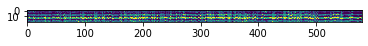

In [90]:
p_descriptors, p_keypoints, p_d_c, kp_time, desc_time = getSpinImageDescriptorsTest(
    pointCloud,
    down_resolution = 5,
    cylindrical_quantization = [4,5],
    verbose=True
)
plt.imshow(np.asarray(p_descriptors,dtype = np.float32).T)
#plt.colorbar()

New: (580, 6)
  desc shape: (579, 4, 5)  kp's shape (579, 6)
  To get keypoints 0.016 seconds, to get descriptors 2.099 seconds


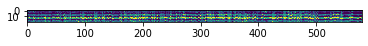

In [92]:
p_descriptors1, p_keypoints1, p_d_c1, kp_time, desc_time = getSpinImageDescriptorsTest1(
    pointCloud,
    down_resolution = 5,
    cylindrical_quantization = [4,5],
    verbose=True
)
plt.imshow(np.asarray(p_descriptors,dtype = np.float32).T)
#plt.colorbar()

In [93]:
np.p_descriptors - p_descriptors1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

New: (580, 6)
Chosen points: (579, 6) Other PC:  (7789, 6) KP shape: (7789, 579, 3)
Theta: (7789, 579) D_a (7789, 579) D_b (7789, 579)
KP shape: (7789, 579, 3) new _a (7789, 579) new _b (7789, 579) mult shape (7789, 579)

  desc shape: (579, 4, 5)  kp's shape (579, 6)
  To get keypoints 0.008 seconds, to get descriptors 4.545 seconds


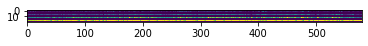

In [48]:
p_descriptors, p_keypoints, p_d_c, kp_time, desc_time = getSpinImageDescriptorsTryTest(
    pointCloud,
    down_resolution = 5,
    cylindrical_quantization = [4,5],
    verbose=True
)
plt.imshow(np.asarray(p_descriptors,dtype = np.float32).T)
#plt.colorbar()

In [49]:
# Getting the "spin image" descriptors for a given point cloud    
_point_cloud = pointCloud#,
resolution = 20#,
normalize = True#,
down_resolution = 5#3, #keypoint resolution
#localize = False,
local_radius = 1.0#,
cylindrical_quantization = [4,5]#[10,20],
verbose = False
old = False
key_cap = 50 
strict_cap = False
    
np_pointCloud = np.asarray(np.copy(_point_cloud))
other_pc = np.copy(np_pointCloud)

t0 = time.time()

if old:
    chosen_points = OLDgetQuantizedPointCloudOnly(np_pointCloud,down_resolution,verbose=verbose)
    if verbose: print("Old:",chosen_points.shape)
else:
    chosen_points = getQuantizedPointCloudOnlyTEST(np_pointCloud,down_resolution,verbose=verbose)
    if verbose: print("New:",chosen_points.shape)

chosen_points = np.delete(chosen_points,np.where(LA.norm(chosen_points[:,3:],axis=1)== 0)[0],0)

t1 = time.time()

if strict_cap and len(chosen_points) > key_cap:
    chosen_points = chosen_points[np.random.choice(len(chosen_points),key_cap)]
    if verbose: print("Capped chosen points to", key_cap)


view_invariant_descriptor_cylinders = np.zeros(
    (np.append(len(chosen_points),
               np.asarray(cylindrical_quantization)
               #np.asarray(cylindrical_quantization*0.5*resolution,dtype = np.uint32)
               #[int(resolution*cylindrical_quantization[0]),int(resolution*cylindrical_quantization[1])]
              )
    ), dtype=np.float16)
#    shape is (number of points, number of a bins, number of b bins)
#print(view_invariant_descriptor_cylinders.shape)

#for i,c_p in enumerate(chosen_points):

k_ps = other_pc[:,np.newaxis,:3] - chosen_points[np.newaxis,:,:3] # point (vertex) differences
#k_ps = np.delete(k_ps,np.where(LA.norm(k_ps,axis=-1)==0)[0],0) # removing itself
print("Chosen points:",chosen_points.shape, "Other PC: ", other_pc.shape, "KP shape:",k_ps.shape)

theta = np.arccos(np.clip(np.sum(chosen_points[np.newaxis,:,:3]*k_ps,axis=-1)/(LA.norm(chosen_points[np.newaxis,:,:3])*LA.norm(k_ps,axis=-1)),-1,1))# normal at keypoint
d_a = cylindrical_quantization[0]*LA.norm(k_ps,axis=-1)*np.sin(theta)
d_b = np.clip(cylindrical_quantization[1]*0.5*LA.norm(k_ps,axis=-1)*np.cos(theta)+cylindrical_quantization[1]*0.5,
              0,cylindrical_quantization[1]-1)

print("Theta:",theta.shape, "D_a", d_a.shape, "D_b", d_b.shape)

i_a = np.ceil(d_a)
i_b = np.ceil(d_b)

diff_a = i_a - d_a
diff_b = i_b - d_b

mult = diff_a*diff_b

print("KP shape:",k_ps.shape, "new _a", diff_a.shape, "new _b", diff_b.shape, "mult shape", mult.shape)

"""
    for k,_ in enumerate(k_ps):

        if LA.norm(k_ps[k]) == 0:
            continue

        # skip points that are beyond the scope of the pre-defined descriptor
        if d_a[k] >= cylindrical_quantization[0]-1 or d_b[k] >= cylindrical_quantization[1]-1:
            continue
        if d_a[k]>a[k] or d_b[k]>b[k]:
            continue
        diff_a = a[k]-d_a[k]
        diff_b = b[k]-d_b[k]
        if diff_a > 1 or diff_b > 1:# or diff_a == 0 or diff_b == 0:
            continue

        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
"""

#np.take(diff_a*diff_b, [[0, 1], [2, 3]])


Chosen points: (579, 6) Other PC:  (7789, 6) KP shape: (7789, 579, 3)
Theta: (7789, 579) D_a (7789, 579) D_b (7789, 579)
KP shape: (7789, 579, 3) new _a (7789, 579) new _b (7789, 579) mult shape (7789, 579)


array([[0.30916797, 0.19664068],
       [0.58485011, 0.39599987]])

(array([  79623.,  501119.,  881461., 1026427.,  855857.,  590778.,
         349131.,  161703.,   57249.,    6483.]),
 array([0.25925793, 0.32520802, 0.39115811, 0.4571082 , 0.52305829,
        0.58900838, 0.65495847, 0.72090856, 0.78685865, 0.85280874,
        0.91875882]),
 <a list of 10 Patch objects>)

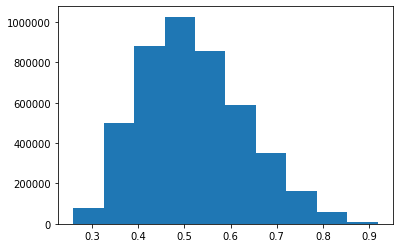

In [82]:
plt.hist(diff_b.flatten())

In [71]:
1-diff_a[0][:3], diff_b[0][:3], ((1-diff_a[0])*(diff_b[0]))[:3]

(array([0.45406726, 0.65380133, 0.00831416]),
 array([0.56631146, 0.56799954, 0.58975342]),
 array([0.25714349, 0.37135886, 0.0049033 ]))

In [83]:
view_invariant_descriptor_cylinders = np.zeros(
    (np.append(len(chosen_points),
               np.asarray(cylindrical_quantization)
              )
    ), dtype=np.float16)

"""
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
"""

for k, k_p in enumerate(k_ps):
    
    submap = np.zeros((len(chosen_points),
        max(cylindrical_quantization[0]+4,int(max(d_a[k]))),
        max(cylindrical_quantization[1]+4,int(max(d_b[k])))
    ))
    
    """
    a_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+3,int(max(i_a[k])))),i_a[k],side="right")-1,0,cylindrical_quantization[0]+2)
    b_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+3,int(max(i_b[k])))),i_b[k],side="right")-1,0,cylindrical_quantization[1]+2)
    a_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+3,int(max(i_a[k])))),i_a[k]-1,side="right")-1,0,cylindrical_quantization[0]+2)
    b_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+3,int(max(i_b[k])))),i_b[k]-1,side="right")-1,0,cylindrical_quantization[1]+2)
    """
    
    a_i = np.clip(np.asarray(i_a[k],dtype = np.uint32),0,cylindrical_quantization[0]+2)
    b_i = np.clip(np.asarray(i_a[k],dtype = np.uint32),0,cylindrical_quantization[1]+2)
    a_i_s = np.clip(np.asarray(i_a[k]-1,dtype = np.uint32),0,cylindrical_quantization[0]+2)
    b_i_s = np.clip(np.asarray(i_a[k]-1,dtype = np.uint32),0,cylindrical_quantization[1]+2)

    if k == 0: print(i_a[k].shape, i_b[k].shape, a_i.shape, b_i.shape, diff_a.shape, diff_b.shape, k_ps.shape)

    submap[np.arange(len(chosen_points)),a_i,b_i] += diff_a[k]*diff_b[k]    
    submap[np.arange(len(chosen_points)),a_i_s,b_i] += (1-diff_a[k])*diff_b[k]
    submap[np.arange(len(chosen_points)),a_i,b_i_s] += diff_a[k]*(1-diff_b[k])
    submap[np.arange(len(chosen_points)),a_i_s,b_i_s] += (1-diff_a[k])*(1-diff_b[k])
    
    view_invariant_descriptor_cylinders += submap[:,:cylindrical_quantization[0],:cylindrical_quantization[1]]


(579,) (579,) (579,) (579,) (7789, 579) (7789, 579) (7789, 579, 3)


(6, 1, 6, 0)

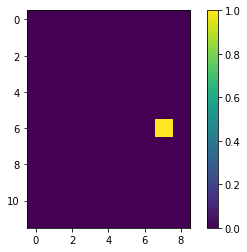

In [68]:
plt.imshow(submap[4])
plt.colorbar()
max(a_i), min(a_i), max(a_i_s), min(a_i_s)

In [24]:


"""
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
"""

for k, k_p in enumerate(k_ps):
    
    submap = np.zeros((len(chosen_points),
        max(cylindrical_quantization[0]+4,int(max(d_a[k]))),
        max(cylindrical_quantization[1]+4,int(max(d_b[k])))
    ))
    
    a_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+3,int(max(i_a[k])))),i_a[k],side="right")-1,0,cylindrical_quantization[0]+2)
    b_i = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+3,int(max(i_b[k])))),i_b[k],side="right")-1,0,cylindrical_quantization[1]+2)
    a_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[0]+3,int(max(i_a[k])))),i_a[k]-1,side="right")-1,0,cylindrical_quantization[0]+2)
    b_i_s = np.clip(np.searchsorted(np.arange(max(cylindrical_quantization[1]+3,int(max(i_b[k])))),i_b[k]-1,side="right")-1,0,cylindrical_quantization[1]+2)

    submap[np.arange(len(chosen_points)),a_i,b_i] += diff_a[k]*diff_b[k]    
    submap[np.arange(len(chosen_points)),a_i_s,b_i] += (1-diff_a[k])*diff_b[k]
    submap[np.arange(len(chosen_points)),a_i,b_i_s] += diff_a[k]*(1-diff_b[k])
    submap[np.arange(len(chosen_points)),a_i_s,b_i_s] += (1-diff_a[k])*(1-diff_b[k])
    
    view_invariant_descriptor_cylinders += submap[:,:cylindrical_quantization[0],:cylindrical_quantization[1]]


In [16]:

"""
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])] += (diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])] += (1-diff_a)*(diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k]),int(b[k])-1] += (diff_a)*(1-diff_b)
        view_invariant_descriptor_cylinders[i,int(a[k])-1,int(b[k])-1] += (1-diff_a)*(1-diff_b)
"""

for k, k_p in enumerate(k_ps):
    
    submap = np.zeros((len(chosen_points),
        max(cylindrical_quantization[0]+4,int(max(d_a[k]))),
        max(cylindrical_quantization[1]+4,int(max(d_b[k])))
    ))
    
    a_i = np.searchsorted(np.arange(max(cylindrical_quantization[0]+2,int(max(i_a[k])))),d_a[k],side="left")-1
    b_i = np.searchsorted(np.arange(max(cylindrical_quantization[1]+2,int(max(i_b[k])))),d_b[k],side="left")-1
    a_i_s = np.searchsorted(np.arange(max(cylindrical_quantization[0]+2,int(max(i_a[k])))),d_a[k]-1,side="left")-1
    b_i_s = np.searchsorted(np.arange(max(cylindrical_quantization[1]+2,int(max(i_b[k])))),d_b[k]-1,side="left")-1

    submap[np.arange(len(chosen_points)),a_i,b_i] += diff_a[k]*diff_b[k]    
    submap[np.arange(len(chosen_points)),a_i_s,b_i] += (1-diff_a[k])*diff_b[k]
    submap[np.arange(len(chosen_points)),a_i,b_i_s] += diff_a[k]*(1-diff_b[k])
    submap[np.arange(len(chosen_points)),a_i_s,b_i_s] += (1-diff_a[k])*(1-diff_b[k])
    
    view_invariant_descriptor_cylinders += submap[:,:cylindrical_quantization[0],:cylindrical_quantization[1]]


IndexError: index 8 is out of bounds for axis 1 with size 8

In [69]:
submap[4]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [193]:
d_a[0].shape, max(d_a[0]), d_b[0].shape, max(d_b[0])

((124,), 4.326178217974423, (124,), 2.629131477519797)

In [203]:
int(max(d_a[0]))

4

In [143]:
column_data = ['a', 'b', 'c', 'd', 'e', 'f', 'x']
data = [['a', 'b', 'c'],
        ['d', 'c'],
        ['e', 'f', 'd', 'x']]

lens = [len(item) for item in data]
R = np.repeat(np.arange(len(lens)),lens)
C = np.searchsorted(column_data,np.concatenate(data))

out = np.zeros((len(data), len(column_data)))
out[R,C] = 1

In [147]:
np.concatenate(data)

array(['a', 'b', 'c', 'd', 'c', 'e', 'f', 'd', 'x'], dtype='<U1')

In [117]:
x ,y  = np.where(pointCloud[:,3:]<1.0)
x.shape, y.shape

((3240,), (3240,))

In [118]:
pointCloud.shape,pointCloud[x,y].shape

((1080, 6), (3240,))

In [67]:
quantized_Test = getQuantizedPointCloudOnlyTEST(pointCloud,5)
quantized_Old = getQuantizedPointCloudOnly(pointCloud,5)
"PC shape:",pointCloud.shape, "New kp shape:",quantized_Test.shape, "Old kp shape:", quantized_Old.shape

('PC shape:', (1080, 6), 'New kp shape:', (124, 6), 'Old kp shape:', (133, 6))

In [52]:
pointCloud[:5], quantized_Test[:5], quantized_Old[:5]

(array([[-5.58563555, -0.21339713, -3.11286824,  0.89479535, -0.04303407,
         -0.44439775],
        [-5.57791604, -0.21144887, -3.09751366,  0.89479535, -0.04303407,
         -0.44439775],
        [-5.58693416, -0.22115395, -3.11473186,  0.89479535, -0.04303407,
         -0.44439775],
        [-5.58373302, -0.25518917, -3.10499049,  0.89479535, -0.04303407,
         -0.44439775],
        [-5.62056684, -0.25756632, -3.08486649,  0.97723587,  0.13053232,
         -0.16724644]]),
 array([[-5.8       ,  0.        , -3.4       ,  0.89479535, -0.04303407,
         -0.44439775],
        [-5.8       ,  0.2       , -4.        ,  0.0275722 ,  0.98900503,
         -0.14528874],
        [-5.8       ,  0.2       , -3.8       ,  0.0275722 ,  0.98900503,
         -0.14528874],
        [-5.8       ,  0.2       , -3.6       ,  0.89479535, -0.04303407,
         -0.44439775],
        [-5.8       ,  0.2       , -3.4       ,  0.89479535, -0.04303407,
         -0.44439775]]),
 array([[-5.58563555, -0.2

In [55]:
pointCloud.shape

(1080, 6)